In [1]:
import pandas as pd
import datetime
from textblob import TextBlob
import googletrans
from googletrans import Translator
import spacy
import en_core_web_sm
# import en_core_web_lg
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
# import youtube_dl
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import plotly as py
import numpy as np


c:\Users\jaden\OneDrive\Coding\Program\Python 3.11\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Song Request Data Analysis
Table: Submission Time, Date, Hours, Location, Artist, Song
Addition: Release date, Genre

1. Top requested songs
   1. Top song genre
   2. Top song released year
2. Top requested artists
3. Top requested location
4. Matching rate based on our playlist

In [2]:

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('Music Request Apr.csv', encoding= 'utf-8')

# Convert the date format to date and hour format in different columns
df['Submission Time'] = pd.to_datetime(df['Submission Time'])
df['Date'] = df['Submission Time'].dt.date
df['Hours'] = df['Submission Time'].dt.time

# Order the data by time frame
df = df.sort_values(by='Submission Time', ascending=False)
df = df.drop(columns=['Event Date'])

# Shift column
df.insert(1, 'Event Date', df['Date'])
df.insert(2, 'Event Hours', df['Hours'])
df = df.drop(columns=['Date', 'Hours'])

# Show the resulting DataFrame
df.head()



,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
3247,2023-04-02 01:57:01+00:00,2023-04-02,01:57:01,Korea,Blackpink,Boombayah
2065,2023-04-02 01:36:18+00:00,2023-04-02,01:36:18,Cologne,BTS,Mic Drop (Steve Aoki Vers)
571,2023-04-02 01:28:55+00:00,2023-04-02,01:28:55,Cologne,Twice,Likey
3480,2023-04-02 01:20:33+00:00,2023-04-02,01:20:33,Cologne,NCT Dream,Fire alarm
5227,2023-04-02 01:05:23+00:00,2023-04-02,01:05:23,Cologne,Nct 127,Firetruck


In [3]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_36304\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
count,6438,6438,6438,6438,6389,6438
unique,6367,82,5596,204,1177,2603
top,2022-11-11 21:38:25+00:00,2022-12-03,21:55:05,Amsterdam,BTS,Maniac
freq,3,344,4,783,339,73
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN
last,2023-04-02 01:57:01+00:00,NaN,NaN,NaN,NaN,NaN


In [4]:
# Seprate the 'Song' data if the 'Song' has multiple songs

df = df.assign(Song=df['Song'].str.split(', ')).explode('Song').reset_index(drop=True)

In [5]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_36304\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
count,6559,6559,6559,6559,6508,6559
unique,6367,82,5596,204,1177,2602
top,2023-01-28 22:44:17+00:00,2022-12-03,21:38:25,Amsterdam,BTS,Maniac
freq,4,363,5,792,347,77
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN
last,2023-04-02 01:57:01+00:00,NaN,NaN,NaN,NaN,NaN


In [6]:
df.head(100)

,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
0,2023-04-02 01:57:01+00:00,2023-04-02,01:57:01,Korea,Blackpink,Boombayah
1,2023-04-02 01:36:18+00:00,2023-04-02,01:36:18,Cologne,BTS,Mic Drop (Steve Aoki Vers)
2,2023-04-02 01:28:55+00:00,2023-04-02,01:28:55,Cologne,Twice,Likey
3,2023-04-02 01:20:33+00:00,2023-04-02,01:20:33,Cologne,NCT Dream,Fire alarm
4,2023-04-02 01:05:23+00:00,2023-04-02,01:05:23,Cologne,Nct 127,Firetruck
...,...,...,...,...,...,...
95,2023-04-01 21:52:07+00:00,2023-04-01,21:52:07,Cologne,TXT,Sugar Rush Ride
96,2023-04-01 21:52:07+00:00,2023-04-01,21:52:07,Cologne,Stray Kids,Miroh
97,2023-04-01 21:51:39+00:00,2023-04-01,21:51:39,köln,ive,love dive
98,2023-04-01 21:49:51+00:00,2023-04-01,21:49:51,Cologne,DKZ,Uh-Heung


In [7]:
# Define the correct city names
correct_cities = ['Munich', 'Vienna', 'Stuttgart', 'Leipzig', 'Frankfurt', 'Berlin', 'Dusseldorf', 'Mannheim', 'Hanover', 'Erlangen', 'Nuremberg', 'Cologne', 'Prague', 'Zurich', 'Dresden', 'Lausanne', 'Hamburg', 'Basel', 'Amsterdam', 'Bremen', 'Milan', 'Copenhagen', 'Paris']


# Use fuzzy string matching to correct the misspelled city names
for city in df['Event Location'].unique():
    if city not in correct_cities:
        matches = process.extract(city, correct_cities, limit=1, scorer=fuzz.token_sort_ratio)
        df['Event Location'].replace({city: matches[0][0]}, inplace=True)

# Show the resulting DataFrame
print(df.head())

            Submission Time  Event Date Event Hours Event Location     Artist  \
0 2023-04-02 01:57:01+00:00  2023-04-02    01:57:01     Copenhagen  Blackpink   
1 2023-04-02 01:36:18+00:00  2023-04-02    01:36:18        Cologne        BTS   
2 2023-04-02 01:28:55+00:00  2023-04-02    01:28:55        Cologne      Twice   
3 2023-04-02 01:20:33+00:00  2023-04-02    01:20:33        Cologne  NCT Dream   
4 2023-04-02 01:05:23+00:00  2023-04-02    01:05:23        Cologne    Nct 127   

                         Song  
0                   Boombayah  
1  Mic Drop (Steve Aoki Vers)  
2                       Likey  
3                  Fire alarm  
4                   Firetruck  


In [8]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_36304\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
count,6559,6559,6559,6559,6508,6559
unique,6367,82,5596,21,1177,2602
top,2023-01-28 22:44:17+00:00,2022-12-03,21:38:25,Amsterdam,BTS,Maniac
freq,4,363,5,928,347,77
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN
last,2023-04-02 01:57:01+00:00,NaN,NaN,NaN,NaN,NaN


In [9]:
df['Song']

0                        Boombayah
1       Mic Drop (Steve Aoki Vers)
2                            Likey
3                       Fire alarm
4                        Firetruck
                   ...            
6554                       Sticker
6555                      BIRTHDAY
6556                      Case 143
6557                     On and on
6558                            ON
Name: Song, Length: 6559, dtype: object

In [10]:

#remove special characters from columns
df['Song'] = df['Song'].str.replace('\W', '', regex=True)
df['Artist'] = df['Artist'].str.replace('\W', '', regex=True)


In [11]:
df.head()

,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
0,2023-04-02 01:57:01+00:00,2023-04-02,01:57:01,Copenhagen,Blackpink,Boombayah
1,2023-04-02 01:36:18+00:00,2023-04-02,01:36:18,Cologne,BTS,MicDropSteveAokiVers
2,2023-04-02 01:28:55+00:00,2023-04-02,01:28:55,Cologne,Twice,Likey
3,2023-04-02 01:20:33+00:00,2023-04-02,01:20:33,Cologne,NCTDream,Firealarm
4,2023-04-02 01:05:23+00:00,2023-04-02,01:05:23,Cologne,Nct127,Firetruck


In [12]:
df.to_csv('song_request_apr_4th.csv', index=True, encoding='utf-8')

In [13]:
df.head()

,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
0,2023-04-02 01:57:01+00:00,2023-04-02,01:57:01,Copenhagen,Blackpink,Boombayah
1,2023-04-02 01:36:18+00:00,2023-04-02,01:36:18,Cologne,BTS,MicDropSteveAokiVers
2,2023-04-02 01:28:55+00:00,2023-04-02,01:28:55,Cologne,Twice,Likey
3,2023-04-02 01:20:33+00:00,2023-04-02,01:20:33,Cologne,NCTDream,Firealarm
4,2023-04-02 01:05:23+00:00,2023-04-02,01:05:23,Cologne,Nct127,Firetruck


In [35]:
# Set up Spotipy client
client_credentials_manager = SpotifyClientCredentials(client_id='5bfef1fd889641d08e029c22f6e5d899', client_secret='92dafad372dc4145b05cb13b7f29df2b')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to search and update song and artist names
def search_and_update(row):
    query = f'{row["Song"]} {row["Artist"]}'
    results = sp.search(q=query, type='track', limit=1)
    
    if results['tracks']['total'] > 0:
        track = results['tracks']['items'][0]
        corrected_song = track['name']
        corrected_artist = track['artists'][0]['name']
        
        row['Song'] = corrected_song
        row['Artist'] = corrected_artist
    return row

# Update the DataFrame with corrected data
df_corrected = df.apply(search_and_update, axis=1)

# Save the corrected data to a new CSV file
df_corrected.to_csv('corrected_data.csv', index=False)

In [37]:
df_corrected.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_52920\591156464.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_corrected.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
count,5393,5393,5393,5393,5393,5393
unique,5338,75,4793,179,549,1306
top,2022-11-11 21:38:25+00:00,2022-12-03,23:48:08,Berlin,Stray Kids,Run BTS
freq,3,344,4,581,520,120
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN
last,2023-03-13 17:35:28+00:00,NaN,NaN,NaN,NaN,NaN


In [41]:
# Define the correct city names
correct_cities = ['Munich', 'Vienna', 'Stuttgart', 'Leipzig', 'Frankfurt', 'Berlin', 'Dusseldorf', 'Mannheim', 'Hanover', 'Erlangen', 'Nuremberg', 'Cologne', 'Prague', 'Zurich', 'Dresden', 'Lausanne', 'Hamburg', 'Basel', 'Amsterdam', 'Bremen', 'Milan', 'Copenhagen', 'Paris']


# Use fuzzy string matching to correct the misspelled city names
for city in df_corrected['Event Location'].unique():
    if city not in correct_cities:
        matches = process.extract(city, correct_cities, limit=5, scorer=fuzz.token_sort_ratio)
        df_corrected['Event Location'].replace({city: matches[0][0]}, inplace=True)

# Show the resulting DataFrame
print(df_corrected.describe())

                  Submission Time  Event Date Event Hours Event Location  \
count                        5393        5393        5393           5393   
unique                       5338          75        4793             21   
top     2022-11-11 21:38:25+00:00  2022-12-03    23:48:08      Amsterdam   
freq                            3         344           4            675   
first   2022-10-27 14:02:37+00:00         NaN         NaN            NaN   
last    2023-03-13 17:35:28+00:00         NaN         NaN            NaN   

            Artist     Song  
count         5393     5393  
unique         549     1306  
top     Stray Kids  Run BTS  
freq           520      120  
first          NaN      NaN  
last           NaN      NaN  


C:\Users\jaden\AppData\Local\Temp\ipykernel_52920\281709818.py:12: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_corrected.describe())


In [42]:
df_corrected.to_csv('corrected_data_updated.csv', index=False)

In [ ]:
# import requests


# # Function to search for artist and song on MusicBrainz
# def search_musicbrainz(artist, song):
#     url = "https://musicbrainz.org/ws/2/recording"
#     params = {
#         "fmt": "json",
#         "query": f'recording:"{song}" AND artist:"{artist}"',
#         "limit": 1
#     }
#     response = requests.get(url, params=params)
#     if response.status_code == 200:
#         data = response.json()
#         if data["count"] > 0:
#             return data["recordings"][0]["artist-credit"][0]["name"], data["recordings"][0]["title"]
#     return artist, song

# # Clean the data
# for index, row in df.iterrows():
#     artist, song = search_musicbrainz(row['Artist'], row['Song'])
#     df.at[index, 'Artist'] = artist
#     df.at[index, 'Song'] = song

# # Print cleaned data
# print(df)

In [33]:
# # Remove spaces between words in the 'Song' and 'Artist' columns

# df[['Artist', 'Song']] = df[['Artist', 'Song']].apply(lambda x: x.str.replace(' ', ''))
# df['Song'] = df['Song'].str.strip()
# df['Artist'] = df['Artist'].str.strip()

In [ ]:
# # Change all letters to lowercase in the 'Song' and 'Artist' columns
# df['Song'] = df['Song'].str.lower()
# df['Artist'] = df['Artist'].str.lower()
# df.head(30)

In [49]:
# Read the text file into a Pandas dataframe
df_r = pd.read_csv('playlist_mar_2023.txt', delimiter='\t', encoding='utf-16')

# Convert all columns to string
df_r = df_r.astype(str)

# Save the modified dataframe to a CSV file with UTF-16 encoding
df_r.to_csv('Playlist_2023_Mar.csv', index=True, encoding='utf-16')


In [50]:
df_r.head()

,#,Artwork,Track Title,Artist,Album,Genre,BPM,Rating,Time,Key,Date Added
0,1,nan,Oh my god,(여자)아이들,I trust,Dance,110.0,,03:15,Em,2023-03-14
1,2,nan,해변 (illa illa),B.I,WATERFALL,Rap / Hip-hop,101.0,,03:25,Bm,2023-03-14
2,3,nan,BAE BAE,BIGBANG,M,Rap,140.0,,02:49,Dm,2023-03-14
3,4,nan,EUNG FREESTYLE (응프리스타일),"LIVE, SIK-K, PUNCHNELLO, OWEN OVADOZ, FLOWSIK",nan,nan,137.9,,02:31,Dm,2023-03-14
4,5,nan,Ko Ko Bop,EXO,THE WAR - The 4th Album,Reggae,146.0,,03:10,Dm,2023-03-14


In [51]:
# Drop the 'Artwork', ' Rating', 'Date Added', 'Time' columns
# Replace comlumns names

df_r.drop(['Artwork', 'Rating', 'Date Added', 'Time'], axis=1, inplace=True)
df_r.rename(columns={'Track Title': 'Song'}, inplace=True)
df_r.head()

,#,Song,Artist,Album,Genre,BPM,Key
0,1,Oh my god,(여자)아이들,I trust,Dance,110.0,Em
1,2,해변 (illa illa),B.I,WATERFALL,Rap / Hip-hop,101.0,Bm
2,3,BAE BAE,BIGBANG,M,Rap,140.0,Dm
3,4,EUNG FREESTYLE (응프리스타일),"LIVE, SIK-K, PUNCHNELLO, OWEN OVADOZ, FLOWSIK",nan,nan,137.9,Dm
4,5,Ko Ko Bop,EXO,THE WAR - The 4th Album,Reggae,146.0,Dm


In [53]:
# Set up Spotipy client
client_credentials_manager = SpotifyClientCredentials(client_id='5bfef1fd889641d08e029c22f6e5d899', client_secret='92dafad372dc4145b05cb13b7f29df2b')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to search and update song and artist names
def search_and_update(row):
    query = f'{row["Song"]} {row["Artist"]}'
    results = sp.search(q=query, type='track', limit=1)
    
    if results['tracks']['total'] > 0:
        track = results['tracks']['items'][0]
        corrected_song = track['name']
        corrected_artist = track['artists'][0]['name']
        
        row['Song'] = corrected_song
        row['Artist'] = corrected_artist
    return row

# Update the DataFrame with corrected data
df_r_corrected = df_r.apply(search_and_update, axis=1)

# Save the corrected data to a new CSV file
df_r_corrected.to_csv('corrected_playlist_data.csv', index=False)

In [58]:
def check_match(row, df_r_corrected):
    song = row['Song']
    artist = row['Artist']
    return df_r_corrected[(df_r_corrected['Song'] == song) & (df_r_corrected['Artist'] == artist)].shape[0] > 0

df_corrected['Playlist'] = df_corrected.apply(lambda row: 'Matched' if check_match(row, df_r_corrected) else 'Unmatched', axis=1)


In [60]:
df_corrected.head()

,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Playlist
1013,2023-03-13 17:35:28+00:00,2023-03-13,17:35:28,Zurich,KAI,Rover,Unmatched
4705,2023-03-13 17:35:09+00:00,2023-03-13,17:35:09,Zurich,KAI,Bomba,Unmatched
4120,2023-03-12 02:43:50+00:00,2023-03-12,02:43:50,Berlin,Simon Dominic,TTFU,Matched
478,2023-03-12 02:43:21+00:00,2023-03-12,02:43:21,Berlin,Simon Dominic,Simon Dominic,Unmatched
446,2023-03-12 02:40:13+00:00,2023-03-12,02:40:13,Berlin,toigo,"BLUE CHECK (Feat. Jay Park, Jessi) (Prod. by S...",Unmatched


In [61]:
df_corrected.to_csv('final_report.csv', index=False)

In [4]:
df = pd.read_excel('final_report.xlsx')

In [8]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_26356\3627053830.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Playlist
count,5350,5350,5350,5350,5350,5350,5350
unique,5296,75,4759,21,540,1277,2
top,2022-11-11 21:38:25+00:00,2022-12-03 00:00:00,22:50:05,Amsterdam,Stray Kids,Run BTS,Unmatched
freq,3,340,4,667,520,120,2701
first,NaN,2022-10-27 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2023-03-13 00:00:00,NaN,NaN,NaN,NaN,NaN


In [6]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import pdfkit
import img2pdf
import os

df = pd.read_excel('final_report.xlsx')

# # Use orca as the default image renderer
# pio.renderers.default = 'orca'

# Top 30 Songs in Bar Chart
top_songs = df['Song'].value_counts().sort_values(ascending=False)[:30]
fig1 = px.bar(top_songs, x=top_songs.index, y=top_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 30 Songs Requested')
fig1.update_traces(marker_color=px.colors.qualitative.Plotly)
fig1.update_layout(
    width=1200,
    height=600,
    xaxis_tickangle=-45,
    margin=dict(l=50, r=50, t=80, b=50)
)
fig1.show()

# Top 30 Artists in Bar Chart
top_artists = df['Artist'].value_counts().sort_values(ascending=False)[:30]
fig2 = px.bar(top_artists, x=top_artists.index, y=top_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 30 Artists Requested')
fig2.update_traces(marker_color=px.colors.qualitative.D3)
fig2.update_layout(
    width=1200,
    height=600,
    xaxis_tickangle=-45,
    margin=dict(l=50, r=50, t=80, b=50)
)
fig2.show()

# Pie Chart for Song Matching Rate
def create_pie_chart(df, column, title):
    match_counts = df[column].value_counts().reset_index()
    fig = px.pie(match_counts, values=column, names='index', title=title)
    return fig

fig3 = create_pie_chart(df, 'Playlist', 'Song Matching Rate')
fig3.show()

# Top 10 Unmatched Songs with Artist Names
unmatched = df[df['Playlist'] == 'Unmatched']
top_unmatched = unmatched['Song'].value_counts().head(10).reset_index()
top_unmatched.columns = ['Song', 'Count']

def get_artist(song):
    return unmatched[unmatched['Song'] == song]['Artist'].iloc[0]

top_unmatched['Artist'] = top_unmatched['Song'].apply(get_artist)
top_unmatched['Song_Artist'] = top_unmatched['Song'] + ' - ' + top_unmatched['Artist']

fig4 = px.bar(top_unmatched, x='Song_Artist', y='Count', title='Top 10 Unmatched Songs with Artist Names', labels={'Song_Artist': 'Song - Artist', 'Count': 'Unmatched Count'})

# Customize the chart's width, height, and colors
fig4.update_layout(
    width=1200,
    height=600,
    xaxis_tickangle=-45,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig4.update_traces(marker_color=px.colors.qualitative.Bold)  # Change the bar colors to a more colorful palette

fig4.show()



# # Convert the figures to HTML and concatenate them
# html_string = pio.to_html(fig1, full_html=False) + pio.to_html(fig2, full_html=False) + pio.to_html(fig3, full_html=False) + pio.to_html(fig4, full_html=False)

# # Add surrounding HTML tags
# html_string = '<html><head><meta charset="utf-8"></head><body>' + html_string + '</body></html>'

# # Save the concatenated HTML string as a PDF
# pdfkit.from_string(html_string, 'output.pdf')

# # Save images as PNG files
# pio.write_image(fig1, 'fig1.png')
# pio.write_image(fig2, 'fig2.png')
# pio.write_image(fig3, 'fig3.png')
# pio.write_image(fig4, 'fig4.png')

# # Combine PNG images into a PDF
# with open("final_report.pdf", "wb") as f:
#     f.write(img2pdf.convert(['fig1.png', 'fig2.png', 'fig3.png', 'fig4.png']))

# # Clean up the PNG files after creating the PDF
# os.remove('fig1.png')
# os.remove('fig2.png')
# os.remove('fig3.png')
# os.remove('fig4.png')


In [16]:
from PIL import Image
import io
import base64

describe_df = df.describe().round(2).reset_index()
describe_table = describe_df.to_html(classes='table', index=False, border=0)

def fig_to_base64(fig):
    buf = io.BytesIO()
    fig.write_image(buf, format='png')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    return img_base64

# Convert the figures to base64-encoded strings
fig1_base64 = fig_to_base64(fig1)
fig2_base64 = fig_to_base64(fig2)
fig3_base64 = fig_to_base64(fig3)
fig4_base64 = fig_to_base64(fig4)

# Update the HTML string to include the base64-encoded images
html = f"""
<!DOCTYPE html>
<html>
<head>
<style>
table {{
  width:100%;
  border-collapse: collapse;
}}
table, th, td {{
  border: 1px solid black;
  padding: 15px;
  text-align: left;
}}
th {{
  background-color: #f2f2f2;
}}
</style>
</head>
<body>

<h2>Total 5350 Song Request from Nov 1st, 2022 to Mar 11th, 2023</h2>
<br>
<br>

<h2>Summary Statistics</h2>
<br>
<h3>Count: Total number of data collected</h3>
<h3>Unique: Total number of unique data sorted</h3>
{describe_table}

<br>
<br>
<br>
<br>
<br>
<br>
<br>

<h2>Top 30 Songs Requested</h2>
<br>
<img src="data:image/png;base64,{fig1_base64}" alt="Top 30 Songs Requested">

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<h2>Top 30 Artists Requested</h2>
<br>
<img src="data:image/png;base64,{fig2_base64}" alt="Top 30 Artists Requested">

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<h2>Song Matching Rate</h2>
<br>
<img src="data:image/png;base64,{fig3_base64}" alt="Song Matching Rate">

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<h2>Top 10 Unmatched Songs with Artist Names</h2>
<br>
<img src="data:image/png;base64,{fig4_base64}" alt="Top 10 Unmatched Songs with Artist Names">


</body>
</html>
"""

# Save the HTML file
with open("report.html", "w") as f:
    f.write(html)

# Save the HTML file as a PDF
pdfkit.from_file("report.html", "report.pdf")


C:\Users\jaden\AppData\Local\Temp\ipykernel_26356\2846923947.py:5: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



True

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os
import plotly.io as pio
from PyPDF2 import PdfFileMerger

df = pd.read_excel('final_report.xlsx')

# Top 30 Songs in Bar Chart
top_songs = df['Song'].value_counts().sort_values(ascending=False)[:30]
fig1 = px.bar(top_songs, x=top_songs.index, y=top_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 30 Songs Requested')
fig1.update_traces(marker_color=px.colors.qualitative.Plotly)
fig1.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
fig1.show()

# Top 30 Artists in Bar Chart
top_artists = df['Artist'].value_counts().sort_values(ascending=False)[:30]
fig2 = px.bar(top_artists, x=top_artists.index, y=top_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 30 Artists Requested')
fig2.update_traces(marker_color=px.colors.qualitative.D3)
fig2.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
fig2.show()

def create_pie_chart(df, column, title):
    match_counts = df[column].value_counts().reset_index()
    fig = px.pie(match_counts, values=column, names='index', title=title)
    return fig

create_pie_chart(df, 'Playlist', 'Song Matching Rate')

unmatched = df[df['Playlist'] == 'Unmatched']

top_unmatched = unmatched['Song'].value_counts().head(10).reset_index()
top_unmatched.columns = ['Song', 'Count']

def get_artist(song):
    return unmatched[unmatched['Song'] == song]['Artist'].iloc[0]

top_unmatched['Artist'] = top_unmatched['Song'].apply(get_artist)
top_unmatched['Song_Artist'] = top_unmatched['Song'] + ' - ' + top_unmatched['Artist']


# def create_bar_chart(df, column, title):
#     top_10 = df[column].value_counts().nlargest(10).reset_index()
#     fig = px.bar(top_10, x='index', y=column, text=column, labels={'index': column})
#     fig.update_traces(texttemplate='%{text}', textposition='outside')
#     fig.update_layout(title_text=title, xaxis_title=column, yaxis_title='Count')
#     fig.show()

# create_bar_chart(unmatched_data, 'Song', 'Top 10 Unmatched Songs')
# create_bar_chart(unmatched_data, 'Artist', 'Top 10 Unmatched Artists')

# def create_bar_chart(df, column, title, top_n=10):
#     top_n_values = df[column].value_counts().nlargest(top_n).reset_index()
#     fig = px.bar(top_n_values, x='index', y=column, text=column, labels={'index': column})
#     fig.update_traces(texttemplate='%{text}', textposition='outside')
#     fig.update_layout(title_text=title, xaxis_title=column, yaxis_title='Count')
#     fig.show()

# # Extract hour from 'Event Hours' column
# df['Hour'] = pd.to_datetime(df['Event Hours']).dt.hour

# create_bar_chart(df, 'Hour', 'Top 5 Requested Hours', top_n=5)
# create_bar_chart(df, 'Event Location', 'Top 5 Locations', top_n=5)



In [75]:
import os
import plotly.io as pio

pio.orca.config.executable = '/path/to/orca'  # Specify the path to the orca executable if it's not in your PATH

if not os.path.exists('images'):
    os.mkdir('images')

fig1.write_image('images/fig1.png')
fig2.write_image('images/fig2.png')
fig3.write_image('images/fig3.png')




ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [28]:
import time

# Set up Spotify API credentials
# client_id = 'YOUR_CLIENT_ID'
# client_secret = 'YOUR_CLIENT_SECRET'

client_credentials_manager = SpotifyClientCredentials(client_id='5bfef1fd889641d08e029c22f6e5d899', client_secret='92dafad372dc4145b05cb13b7f29df2b')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


# Define the threshold for matching similarity
similarity_threshold = 80

# Define a dictionary to store matched song names
matched_songs = {}

# Loop through each row in the DataFrame
for i in range(len(df_r)):
    track_title = df_r.at[i, 'Song']
    artist = df_r.at[i, 'Artist']
    
    # Search for the track on Spotify
    result = sp.search(q=track_title + ' ' + artist, type='track')
    
    # Check if any tracks were found
    if len(result['tracks']['items']) > 0:
        # Loop through the search results and find the best match based on similarity score
        max_similarity = 0
        max_sim_track = ''
        for track in result['tracks']['items']:
            sim_track = fuzz.token_set_ratio(track_title, track['name'])
            sim_artist = fuzz.token_set_ratio(artist, track['artists'][0]['name'])
            if sim_track + sim_artist > max_similarity and sim_track + sim_artist >= similarity_threshold:
                max_similarity = sim_track + sim_artist
                max_sim_track = track['name']
                max_sim_artist = track['artists'][0]['name']
                # album = track['album']['name']
                # genre = sp.artist(track['artists'][0]['id'])['genres'][0]
                # bpm = track['tempo']
                # key = track['key']
        
        # If a match was found, update the DataFrame
        if max_similarity > 0:
            df_r.at[i, 'Song'] = max_sim_track
            df_r.at[i, 'Artist'] = max_sim_artist
            # df_r.at[i, 'Album'] = album
            # df_r.at[i, 'Genre'] = genre
            # df_r.at[i, 'BPM'] = bpm
            # df_r.at[i, 'Key'] = key
            df_r.at[i, 'Matched'] = 'Matched'
        else:
            df_r.at[i, 'Matched'] = 'Not Matched'
            
            
        # for track in result['tracks']['items']:
        #     match_track = process.extract(track_title, track['name'], limit=1, scorer=fuzz.token_sort_ratio)
        #     match_artist = process.extract(artist, track['artists'][0]['name'], limit=1, scorer=fuzz.token_sort_ratio)
        #     if match_track + match_artist is not None:
        #         df_r.at[i, 'Song'] = match_track
        #         df_r.at[i, 'Artist'] = match_artist
        #         df_r.at[i, 'Matched'] = 'Matched'
        #     else:
        #         df_r.at[i, 'Song'] = ""
        #         df_r.at[i, 'Artist'] = ""
        #         df_r.at[i, 'Matched'] = 'Not Matched'

                
        # # If a match was found, update the DataFrame
        # if max_similarity > -1:
        #     df_r.at[i, 'Song'] = max_sim_track['name']
        #     df_r.at[i, 'Artist'] = max_sim_track['artists'][0]['name']
        #     df_r.at[i, 'Matched'] = 'Matched'
        #     df_r.at[i, 'Spotify URI'] = max_sim_track['uri']
        #     df_r.at[i, 'Album'] = max_sim_track['album']['name']
            
    # Wait for a short time to avoid hitting rate limits
    time.sleep(0.2)
        
# Save the updated DataFrame to a new CSV file
df_r.to_csv('Playlist_2023_Mar_updated.csv', index=False)


In [43]:
# Read the text file into a Pandas dataframe
df_u = pd.read_excel('Playlist_2023_March.xlsx')

In [44]:
df_u.head()

,#,Song,Artist,Genre,BPM,Key,Matched
0,1,Oh my god,(G)I-DLE,Dance,110.0,Em,Matched
1,2,illa illa,B.I,Rap / Hip-hop,101.0,Bm,Matched
2,3,BAE BAE,BIGBANG,Rap,140.0,Dm,Matched
3,4,DDDD Freestyle,Sik-K,NaN,137.9,Dm,Matched
4,5,Ko Ko Bop,EXO,Reggae,146.0,Dm,Matched


In [54]:
# # Read the Music Request csv file
# df_mr = pd.read_csv('Music Request Mar.csv')

# # Read the Playlist excel file
# df_pl = pd.read_excel('Playlist_2023_March.xlsx')

# Convert all columns to string
df_mr = df_corrected
df_pl = df_r_corrected

# Define the threshold for matching similarity
similarity_threshold = 80

# Loop through each row in the Music Request dataframe
for i in range(len(df_mr)):
    # Get the Song and Artist values from the Music Request dataframe
    song_mr = df_mr.at[i, 'Song']
    artist_mr = df_mr.at[i, 'Artist']
    
    # Loop through each row in the Playlist dataframe
    for j in range(len(df_pl)):
        # Get the Song and Artist values from the Playlist dataframe
        song_pl = df_pl.at[j, 'Song']
        artist_pl = df_pl.at[j, 'Artist']
        
        # Check if the Song and Artist values match above the similarity threshold
        if fuzz.token_sort_ratio(song_mr, song_pl) >= similarity_threshold and fuzz.token_sort_ratio(artist_mr, artist_pl) >= similarity_threshold:
            # If a match is found, update the Music Request dataframe and break out of the inner loop
            df_mr.at[i, 'Playlist'] = 'Matched'

        else:
            # If no match is found, mark the row as 'Unmatched'
            df_mr.at[i, 'Playlist'] = 'Unmatched'
        
# # Save the updated Music Request DataFrame to a new csv file
# df_mr.to_csv('Music Request Mar processed.csv', index=False)

In [55]:
df_mr.head()

,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Playlist
1013,2023-03-13 17:35:28+00:00,2023-03-13,17:35:28,Zurich,KAI,Rover,Unmatched
4705,2023-03-13 17:35:09+00:00,2023-03-13,17:35:09,Zurich,KAI,Bomba,Unmatched
4120,2023-03-12 02:43:50+00:00,2023-03-12,02:43:50,Berlin,Simon Dominic,TTFU,Unmatched
478,2023-03-12 02:43:21+00:00,2023-03-12,02:43:21,Berlin,Simon Dominic,Simon Dominic,Unmatched
446,2023-03-12 02:40:13+00:00,2023-03-12,02:40:13,Berlin,toigo,"BLUE CHECK (Feat. Jay Park, Jessi) (Prod. by S...",Unmatched


In [59]:
df_corrected.to_csv('Music Playlist Matching.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'Music Playlist Matching.csv'

In [71]:

from requests.exceptions import ReadTimeout
# # Read the Music Request CSV file into a Pandas DataFrame
# df_mr = pd.read_csv('Music Request Mar.csv')

# # Create a new column 'Playlist' with all values initialized as 'Unmatched'
# df_mr['Playlist'] = 'Unmatched'

# Set up Spotify API credentials
# client_id = 'e37bcb565d19403ea8d29970f515b6bf'
# client_secret = '8c5f640b8b45456aa0eb514aa02df0f5'
client_credentials_manager = SpotifyClientCredentials(client_id='e37bcb565d19403ea8d29970f515b6bf', client_secret='8c5f640b8b45456aa0eb514aa02df0f5', requests_timeout=10)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Loop through each row in the DataFrame
for i, row in df_mr.iterrows():
    song = row['Song']
    artist = row['Artist']
    playlist = row['Playlist']
    
    # Check if the playlist is already matched
    if playlist == 'Unmatched':
        # Search for the track on Spotify
        retries = 3
        while retries > 0:
            try:
                result = sp.search(q=song + ' ' + artist, type='track')
                break
            except ReadTimeout:
                retries -= 1
                if retries == 0:
                    # If all retries fail, mark the track as unfound and move on to the next one
                    df_mr.at[i, 'Spotify'] = 'Unfound'
                    continue

        # Check if any tracks were found
        if len(result['tracks']['items']) > 0:
            # Loop through the search results and find the best match based on similarity score
            max_similarity = 0
            max_sim_track = ''
            for track in result['tracks']['items']:
                match_track = process.extract(song, track['name'], limit=1, scorer=fuzz.token_sort_ratio)
                match_artist = process.extract(artist, track['artists'][0]['name'], limit=1, scorer=fuzz.token_sort_ratio)
                if match_track[0][1] + match_artist[0][1] > max_similarity:
                    max_similarity = match_track[0][1] + match_artist[0][1]
                    max_sim_track = track
            
            # If a match was found, update the DataFrame and mark it as 'Found'
            if max_similarity > 80:
                df_mr.at[i, 'Song'] = max_sim_track['name']
                df_mr.at[i, 'Artist'] = max_sim_track['artists'][0]['name']
                df_mr.at[i, 'Spotify'] = 'Found'
            else:
                df_mr.at[i, 'Spotify'] = 'Unfound'
        else:
            df_mr.at[i, 'Spotify'] = 'Unfound'

    

# Save the updated DataFrame to a new CSV file
df_mr.to_csv('Music Request Mar Searched.csv', index=False)

df_mr.head()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Playlist,Spotify
0,2023-03-13 17:35:28+00:00,2023-03-13,17:35:28,Zurich,Bishop Briggs,River - King Kavalier Remix,Unmatched,Unfound
1,2023-03-13 17:35:09+00:00,2023-03-13,17:35:09,Zurich,King Africa,La Bomba - King Africa Megamix,Unmatched,Unfound
2,2023-03-12 02:43:50+00:00,2023-03-12,02:43:50,Berlin,Simon Dominic,TTFU,Matched,NaN
3,2023-03-12 02:43:21+00:00,2023-03-12,02:43:21,Berlin,Simon Dominic,TTFU (turn the fuck up),Unmatched,Unfound
4,2023-03-12 02:40:13+00:00,2023-03-12,02:40:13,Berlin,J Park,Blue check,Unmatched,Unfound


In [63]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

df = df_mr

# Top 30 Songs in Bar Chart
top_songs = df['Song'].value_counts().sort_values(ascending=False)[:30]
fig1 = px.bar(top_songs, x=top_songs.index, y=top_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 30 Songs Requested')
fig1.update_traces(marker_color=px.colors.qualitative.Plotly)
fig1.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
fig1.show()

# Top 30 Artists in Bar Chart
top_artists = df['Artist'].value_counts().sort_values(ascending=False)[:30]
fig2 = px.bar(top_artists, x=top_artists.index, y=top_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 30 Artists Requested')
fig2.update_traces(marker_color=px.colors.qualitative.D3)
fig2.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
fig2.show()

def create_pie_chart(df, column, title):
    match_counts = df[column].value_counts().reset_index()
    fig = px.pie(match_counts, values=column, names='index', title=title)
    fig.show()

create_pie_chart(df, 'Playlist', 'Song Matching Rate')

unmatched_data = df[df['Playlist'] == 'Unmatched']

def create_bar_chart(df, column, title):
    top_10 = df[column].value_counts().nlargest(10).reset_index()
    fig = px.bar(top_10, x='index', y=column, text=column, labels={'index': column})
    fig.update_traces(texttemplate='%{text}', textposition='outside')
    fig.update_layout(title_text=title, xaxis_title=column, yaxis_title='Count')
    fig.show()

create_bar_chart(unmatched_data, 'Song', 'Top 10 Unmatched Songs')
create_bar_chart(unmatched_data, 'Artist', 'Top 10 Unmatched Artists')

def create_bar_chart(df, column, title, top_n=10):
    top_n_values = df[column].value_counts().nlargest(top_n).reset_index()
    fig = px.bar(top_n_values, x='index', y=column, text=column, labels={'index': column})
    fig.update_traces(texttemplate='%{text}', textposition='outside')
    fig.update_layout(title_text=title, xaxis_title=column, yaxis_title='Count')
    fig.show()

# Extract hour from 'Event Hours' column
df['Hour'] = pd.to_datetime(df['Event Hours']).dt.hour

create_bar_chart(df, 'Hour', 'Top 5 Requested Hours', top_n=5)
create_bar_chart(df, 'Event Location', 'Top 5 Locations', top_n=5)


# # Top 5 Genres in Pie Chart
# top_genres = df['Genre'].value_counts().sort_values(ascending=False)[:5]
# fig3 = px.pie(top_genres, values=top_genres.values, names=top_genres.index, title='Top 5 Genres Requested')
# fig3.update_traces(marker_colors=px.colors.qualitative.Pastel)
# fig3.show()

# # Top 5 Years in Pie Chart
# top_years = df['Release Year'].value_counts().sort_values(ascending=False)[:5]
# fig4 = px.pie(top_years, values=top_years.values, names=top_years.index, title='Top 5 Years Requested')
# fig4.update_traces(marker_colors=px.colors.qualitative.Safe)
# fig4.show()

# # Top Request Hours in Pie Chart
# top_hours = df['Event Hours'].dt.hour.value_counts(normalize=True).sort_index()
# fig5 = go.Figure(df=[go.Pie(labels=top_hours.index.astype(str), values=top_hours.values*100)])
# fig5.update_traces(marker_colors=px.colors.qualitative.Plotly)
# fig5.update_layout(title='Top Request Hours', title_x=0.5, margin=dict(l=50, r=50, t=80, b=50))
# fig5.show()

# # Top 5 Locations in Bar Chart
# top_locations = df['Event Location'].value_counts().sort_values(ascending=False)[:5]
# fig6 = px.bar(top_locations, x=top_locations.index, y=top_locations.values, labels={'x': 'Location', 'y': 'Count'}, title='Top 5 Requested Locations')
# fig6.update_traces(marker_color=px.colors.qualitative.D3)
# fig6.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
# fig6.show()

# # Song Matching Rate Based on Playlist
# fig7 = go.Figure(df=[go.Pie(labels=['Matched', 'Unmatched'], values=[len(df.loc[df['Playlist'] == 'Matched']), len(df.loc[df['Playlist'] == 'Unmatched'])])])
# fig7.update_traces(marker_colors=px.colors.qualitative.Plotly)
# fig7.update_layout(title='Song Matching Rate Based on Playlist', title_x=0.5, margin=dict(l=50, r=50, t=80, b=50))
# fig7.show()

# # Top 5 Unmatched Songs in Bar Chart
# unmatched_songs = df.loc[~df['Song'].isin(playlist['Song']), 'Song'].value_counts().sort_values(ascending=False)[:5]
# fig8 = px.bar(unmatched_songs, x=unmatched_songs.index, y=unmatched_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 5 Unmatched Songs')
# fig8.update_traces(marker_color=px.colors.qualitative.Pastel)
# fig8.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
# fig8.show()

# # Top 5 Unmatched Artists in Bar Chart
# unmatched_artists = df.loc[~df['Artist'].isin(playlist['Artist']), 'Artist'].value_counts().sort_values(ascending=False)[:5]
# fig9 = px.bar(unmatched_artists, x=unmatched_artists.index, y=unmatched_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 5 Unmatched Artists')
# fig9.update_traces(marker_color=px.colors.qualitative.Safe)
# fig9.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
# fig9.show()


In [ ]:
# # Define the correct song, artist names on Spotify
# spotify_song = df_r['Song'].unique()
# spotify_artist = df_r['Artist'].unique()

# # Use fuzzy string matching to correct the song requests in the DataFrame
# for song in df['Song'].unique():
#     if song not in spotify_song:
#         matches = process.extract(song, spotify_song, limit=1, scorer=fuzz.token_sort_ratio)
#         df['Song'].replace({song: matches[0][0]}, inplace=True)
#         if matches is not None:
#             matches_artist = process.extract(artist, spotify_artist, limit=1, scorer=fuzz.token_sort_ratio)
#             df['Matched'] = 'Matched'

# # Show the resulting DataFrame
# print(df.head())

In [65]:
# # Define the correct song names
# correct_songs = df_r['Song'].unique()

# # Use fuzzy string matching to correct the misspelled song names
# df['Matched'] = np.nan
# for i in range(len(df)):
#     song = df.at[i, 'Song']
#     if song in correct_songs:
#         df.at[i, 'Matched'] = 'matched'
#     else:
#         matches = process.extract(song, correct_songs, limit=1, scorer=fuzz.token_sort_ratio)
#         if matches[0][1] >= 80:
#             df.at[i, 'Song'] = matches[0][0]
#             df.at[i, 'Matched'] = 'matched'
#         else:
#             df.at[i, 'Matched'] = 'unmatched'

# # Show the resulting DataFrame
# print(df.head(30))

             Submission Time  Event Date Event Hours Event Location  \
0  2023-03-02 20:21:50+00:00  2023-03-02    20:21:50      Stuttgart   
1  2023-03-02 20:21:45+00:00  2023-03-02    20:21:45      Stuttgart   
2  2023-03-02 20:21:07+00:00  2023-03-02    20:21:07      Stuttgart   
3  2023-03-02 20:19:58+00:00  2023-03-02    20:19:58      Stuttgart   
4  2023-03-02 20:19:48+00:00  2023-03-02    20:19:48      Stuttgart   
5  2023-03-02 20:18:53+00:00  2023-03-02    20:18:53      Stuttgart   
6  2023-03-02 20:17:58+00:00  2023-03-02    20:17:58      Stuttgart   
7  2023-03-02 20:17:18+00:00  2023-03-02    20:17:18      Stuttgart   
8  2023-03-02 20:17:08+00:00  2023-03-02    20:17:08      Stuttgart   
9  2023-03-02 20:15:45+00:00  2023-03-02    20:15:45      Stuttgart   
10 2023-03-02 20:15:36+00:00  2023-03-02    20:15:36      Stuttgart   
11 2023-03-02 20:14:18+00:00  2023-03-02    20:14:18      Stuttgart   
12 2023-03-02 20:14:17+00:00  2023-03-02    20:14:17      Stuttgart   
13 202

In [44]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_50440\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Matched
count,4969,4969,4969,4969,4925,4969,4969
unique,4815,67,4358,176,980,1855,3
top,2023-01-28 22:44:17+00:00,2022-12-03,21:48:06,Amsterdam,BTS,ANTIFRAGILE,unmatched
freq,4,363,5,587,254,74,3352
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-03-02 20:21:50+00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.head()

,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Matched
0,2023-03-02 20:21:50+00:00,2023-03-02,20:21:50,Stuttgart,Rain,Rainism,unmatched
1,2023-03-02 20:21:45+00:00,2023-03-02,20:21:45,Stuttgart,Hyolyn,Say My Name,corrected
2,2023-03-02 20:21:07+00:00,2023-03-02,20:21:07,Stuttgart,Rain,Domestic,unmatched
3,2023-03-02 20:19:58+00:00,2023-03-02,20:19:58,Stuttgart,Hyuna&dawn,Ping pong,unmatched
4,2023-03-02 20:19:48+00:00,2023-03-02,20:19:48,Stuttgart,Shinee,Replay,unmatched


In [46]:
df.to_csv('Music Request Fuzz.csv', index=True, encoding='utf-8')

In [26]:
# # Define the correct song names
# correct_songs = df_r['Song'].unique()

# # Use fuzzy string matching to correct the misspelled song names
# for song in df['Song'].unique():
#     if song not in correct_songs:
#         matches = process.extract(song, correct_songs, limit=1, scorer=fuzz.token_sort_ratio)
#         df['Song'].replace({song: matches[0][0]}, inplace=True)
#     else:
#         continue

# # Show the resulting DataFrame
# df.head(30)

,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
0,2023-03-02 20:21:50+00:00,2023-03-02,20:21:50,Stuttgart,Rain,Ridin’
1,2023-03-02 20:21:45+00:00,2023-03-02,20:21:45,Stuttgart,Hyolyn,Say My Name
2,2023-03-02 20:21:07+00:00,2023-03-02,20:21:07,Stuttgart,Rain,Shut Down
3,2023-03-02 20:19:58+00:00,2023-03-02,20:19:58,Stuttgart,Hyuna&dawn,Ring Ding Dong
4,2023-03-02 20:19:48+00:00,2023-03-02,20:19:48,Stuttgart,Shinee,TELL YA!
5,2023-03-02 20:18:53+00:00,2023-03-02,20:18:53,Stuttgart,BM,Bloody Mary
6,2023-03-02 20:17:58+00:00,2023-03-02,20:17:58,Stuttgart,Monsta x,사랑해 (I LOVE YOU)
7,2023-03-02 20:17:18+00:00,2023-03-02,20:17:18,Stuttgart,Kang Daniel,Anpanman
8,2023-03-02 20:17:08+00:00,2023-03-02,20:17:08,Stuttgart,(G)I-dle,MY BAG
9,2023-03-02 20:15:45+00:00,2023-03-02,20:15:45,Stuttgart,Kang Daniel,Gucci


In [48]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_50440\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Matched
count,4969,4969,4969,4969,4925,4969,4969
unique,4815,67,4358,21,980,1855,3
top,2023-01-28 22:44:17+00:00,2022-12-03,21:48:06,Amsterdam,BTS,ANTIFRAGILE,unmatched
freq,4,363,5,683,254,74,3352
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-03-02 20:21:50+00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# # Load the CSV data into a pandas DataFrame
# df = pd.read_csv('Music Request Feb.csv')

# # Convert the event date data to a standard format
# for i in range(len(df)):
#     try:
#         df.at[i, 'Event Date'] = datetime.datetime.strptime(df.at[i, 'Event Date'], '%d.%m.%Y').strftime('%Y-%m-%d')
#     except:
#         try:
#             df.at[i, 'Event Date'] = datetime.datetime.strptime(df.at[i, 'Event Date'], '%dth %B %Y').strftime('%Y-%m-%d')
#         except:
#             try:
#                 df.at[i, 'Event Date'] = datetime.datetime.strptime(df.at[i, 'Event Date'], '%b %d %Y').strftime('%Y-%m-%d')
#             except:
#                 try:
#                     df.at[i, 'Event Date'] = datetime.datetime.strptime(df.at[i, 'Event Date'], '%b %d, %Y').strftime('%Y-%m-%d')
#                 except:
#                     df.at[i, 'Event Date'] = ''
                    
# df.head(10)
# df.describe()

,Submission Time,Event Location,Event Date,Artist,Song
count,181,181,181,179,181
unique,181,42,25,109,158
top,2023-01-20T22:52:55Z,Amsterdam,,BTS,BTBT
freq,1,23,121,10,6


In [13]:
# # Detect and translate the language of the event location data to English
# translator = Translator()
# for i in range(len(df)):
#     try:
#         location = TextBlob(df.at[i, 'Event Location']).translate(to='en')
#         df.at[i, 'Event Location'] = translator.translate(str(location)).text
#     except:
#         df.at[i, 'Event Location'] = ''


In [79]:

df.to_csv('song_requests_edit_before_nlp5.csv', index=False)
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_34380\827184911.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Submission Time,Event Date,Event Hours,Event Location,Artist,Song
count,4969,4969,4969,4969,4925,4969
unique,4815,67,4358,21,660,1528
top,2023-01-28 22:44:17+00:00,2022-12-03,21:48:06,Amsterdam,bts,runbts
freq,4,363,5,683,437,92
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN
last,2023-03-02 20:21:50+00:00,NaN,NaN,NaN,NaN,NaN


In [49]:
# Correct the typo mistakes in the Artist and Song fields by matching them to real Music data from Spotify or YouTube Music
nlp = en_core_web_lg.load()
client_credentials_manager = SpotifyClientCredentials(client_id='e37bcb565d19403ea8d29970f515b6bf', client_secret='8c5f640b8b45456aa0eb514aa02df0f5')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [50]:
# Define the threshold for matching similarity
similarity_threshold = 80

# Correct the typo mistakes in the Artist and Song fields by matching them to real Music data from Spotify or YouTube Music
for i in range(len(df)):
    artist = df.at[i, 'Artist']
    song = df.at[i, 'Song']
    matched = df.at[i, 'Matched']
    
    # Only update the data if the song is unmatched
    if matched == 'unmatched':
        try:
            result = sp.search(q=song, type='track')
            if len(result['tracks']['items']) > 0:
                max_similarity = -1
                max_sim_song = ''
                for track in result['tracks']['items']:
                    sim_song = fuzz.token_set_ratio(song, track['name'])
                    if sim_song > max_similarity and sim_song >= similarity_threshold:
                        max_similarity = sim_song
                        max_sim_song = track['name']
                        release_year = track['album']['release_date'][:4] # Get release year
                        genre = sp.artist(track['artists'][0]['id'])['genres'][0] # Get genre
                if max_similarity > -1:
                    df.at[i, 'Artist'] = result['tracks']['items'][0]['artists'][0]['name']
                    df.at[i, 'Song'] = max_sim_song
                    df.at[i, 'Release Year'] = release_year # Add release year to dataframe
                    df.at[i, 'Genre'] = genre # Add genre to dataframe
                    df.at[i, 'Matched'] = 'matched' # Set the matched column to matched
            else:
                doc1 = nlp(artist)
                doc2 = nlp(song)
                max_sim_artist = ''
                max_sim_song = ''
                max_similarity = -1
                for filename in os.listdir('music_data'):
                    if filename.endswith('.txt'):
                        with open('music_data/' + filename) as file:
                            data = file.read()
                            doc3 = nlp(data)
                            sim_artist = doc1.similarity(doc3)
                            sim_song = fuzz.ratio(song.lower(), filename.split('.txt')[0].lower())
                            if sim_artist > max_similarity:
                                max_similarity = sim_artist
                                max_sim_artist = filename.split('.txt')[0]
                            if sim_song > max_similarity and sim_song >= similarity_threshold:
                                max_similarity = sim_song
                                max_sim_song = filename.split('.txt')[0]
                                release_year = filename.split('.txt')[1] # Get release year from filename
                                genre = '' # No genre information available for local music data
                if max_similarity > -1:
                    df.at[i, 'Artist'] = max_sim_artist
                    df.at[i, 'Song'] = max_sim_song
                    df.at[i, 'Release Year'] = release_year # Add release year to dataframe
                    df.at[i, 'Genre'] = genre # Add genre to dataframe
                    df.at[i, 'Matched'] = 'corrected' # Set the matched column to corrected
        except:
            pass


In [52]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_50440\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Matched,Release Year,Genre
count,4969,4969,4969,4969,4949,4969,4969,3058,3058
unique,4815,67,4358,21,965,1339,3,47,224
top,2023-01-28 22:44:17+00:00,2022-12-03,21:48:06,Amsterdam,BTS,Run BTS,matched,2022,k-pop
freq,4,363,5,683,350,101,3499,872,1653
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-03-02 20:21:50+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# # Define the correct song names
# correct_songs = df_r['Song'].unique()

# Use fuzzy string matching to correct the misspelled song names
df['Matched'] = np.nan
for i in range(len(df)):
    song = df.at[i, 'Song']
    if song in correct_songs:
        df.at[i, 'Song'] = song
        df.at[i, 'Artist'] = df_r['Artist'].iloc[i]
        df.at[i, 'Matched'] = 'matched'
    else:
        matches = process.extract(song, correct_songs, limit=1, scorer=fuzz.token_sort_ratio)
        if matches[0][1] >= 60:
            df.at[i, 'Song'] = song
            df.at[i, 'Artist'] = df_r['Artist'].iloc[i]
            df.at[i, 'Matched'] = 'matched'
        else:
            df.at[i, 'Matched'] = 'unmatched'

# Show the resulting DataFrame
print(df.head(30))

IndexError: single positional indexer is out-of-bounds

In [82]:
# # Define the threshold for matching similarity
# similarity_threshold = 85

# # Define a dictionary to store matched song names
# matched_songs = {}

# # Correct the typo mistakes in the Artist and Song fields by matching them to real Music data from Spotify or YouTube Music
# for i in range(len(df)):
#     artist = df.at[i, 'Artist']
#     song = df.at[i, 'Song']
#     matched = False
    
#     # Check if the song name has already been matched
#     if song in matched_songs:
#         df.at[i, 'Song'] = matched_songs[song]
#         matched = True
#     else:
#         try:
#             result = sp.search(q=song, type='track')
#             if len(result['tracks']['items']) > 0:
#                 max_similarity = -1
#                 max_sim_song = ''
#                 max_sim_artist = ''
#                 for track in result['tracks']['items']:
#                     sim_song = fuzz.token_set_ratio(song, track['name'])
#                     sim_artist = fuzz.token_set_ratio(artist, track['artists'][0]['name'])
#                     if sim_song > max_similarity and sim_song >= similarity_threshold and sim_artist >= similarity_threshold:
#                         max_similarity = sim_song
#                         max_sim_song = track['name']
#                         max_sim_artist = track['artists'][0]['name']
#                         release_year = track['album']['release_date'][3:4] # Get release month and year
#                         genre = sp.artist(track['artists'][0]['id'])['genres'][0] # Get genre
#                         popularity = track['popularity'] # Get popularity
#                 if max_similarity > -1:
#                     df.at[i, 'Artist'] = track['artists'][0]['name']
#                     df.at[i, 'Song'] = track['name']
#                     df.at[i, 'Release Year'] = release_year # Add release year to dataframe
#                     df.at[i, 'Genre'] = genre # Add genre to dataframe
#                     df.at[i, 'Popularity'] = popularity # Add popularity to dataframe
#                     matched_songs[song] = max_sim_song
#                     matched = True
#             else:
#                 pass
#                 # doc1 = nlp(artist)
#                 # doc2 = nlp(song)
#                 # max_sim_artist = ''
#                 # max_sim_song = ''
#                 # max_similarity = -1
#                 # for filename in os.listdir('music_data'):
#                 #     if filename.endswith('.txt'):
#                 #         with open('music_data/' + filename) as file:
#                 #             data = file.read()
#                 #             doc3 = nlp(data)
#                 #             sim_artist = doc1.similarity(doc3)
#                 #             sim_song = fuzz.ratio(song.lower(), filename.split('.txt')[0].lower())
#                 #             if sim_artist > max_similarity:
#                 #                 max_similarity = sim_artist
#                 #                 max_sim_artist = filename.split('.txt')[0]
#                 #             if sim_song > max_similarity and sim_song >= similarity_threshold:
#                 #                 max_similarity = sim_song
#                 #                 max_sim_song = filename.split('.txt')[0]
#                 #                 release_year = filename.split('.txt')[1] # Get release year from filename
#                 #                 genre = '' # No genre information available for local music data
#                 # if max_similarity > -1:
#                 #     df.at[i, 'Artist'] = max_sim_artist
#                 #     df.at[i, 'Song'] = max_sim_song
#                 #     df.at[i, 'Release Year'] = release_year # Add release year to dataframe
#                 #     df.at[i, 'Genre'] = genre # Add genre to dataframe
#                 #     matched_songs[song] = max_sim_song
#                 #     matched = True
#         except:
#             pass
#     df.at[i, 'Matched'] = 'Matched' if matched else 'Unmatched' # Add column indicating if song was matched or unmatched


In [58]:
df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_50440\3627053830.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Matched,Release Year,Genre
count,4969,4969,4969,4969,4963,4969,280,3058,3058
unique,4815,67,4358,21,811,1339,2,47,224
top,2023-01-28 22:44:17+00:00,2022-12-03,21:48:06,Amsterdam,Stray Kids,Run BTS,unmatched,2022,k-pop
freq,4,363,5,683,243,101,182,872,1653
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-03-02 20:21:50+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# # Clean and preprocess the data
# df = df.dropna()
# df = df.drop_duplicates()
# df = df.reset_index(drop=True)

# df.to_csv('song_requests_edit_nlp_final3.csv', index=False)

In [85]:
df.describe()

,Popularity
count,421.000000
mean,59.073634
std,12.987606
min,0.000000
25%,51.000000
50%,60.000000
75%,68.000000
max,92.000000


In [56]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


# Top 30 Songs in Bar Chart
top_songs = df['Song'].value_counts().sort_values(ascending=False)[:30]
fig1 = px.bar(top_songs, x=top_songs.index, y=top_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 30 Songs Requested')
fig1.update_traces(marker_color=px.colors.qualitative.Plotly)
fig1.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
fig1.show()

# Top 30 Artists in Bar Chart
top_artists = df['Artist'].value_counts().sort_values(ascending=False)[:30]
fig2 = px.bar(top_artists, x=top_artists.index, y=top_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 30 Artists Requested')
fig2.update_traces(marker_color=px.colors.qualitative.D3)
fig2.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
fig2.show()

# Top 5 Genres in Pie Chart
top_genres = df['Genre'].value_counts().sort_values(ascending=False)[:5]
fig3 = px.pie(top_genres, values=top_genres.values, names=top_genres.index, title='Top 5 Genres Requested')
fig3.update_traces(marker_colors=px.colors.qualitative.Pastel)
fig3.show()

# Top 5 Years in Pie Chart
top_years = df['Release Year'].value_counts().sort_values(ascending=False)[:5]
fig4 = px.pie(top_years, values=top_years.values, names=top_years.index, title='Top 5 Years Requested')
fig4.update_traces(marker_colors=px.colors.qualitative.Safe)
fig4.show()

# Top Request Hours in Pie Chart
top_hours = df['Event Hours'].dt.hour.value_counts(normalize=True).sort_index()
fig5 = go.Figure(data=[go.Pie(labels=top_hours.index.astype(str), values=top_hours.values*100)])
fig5.update_traces(marker_colors=px.colors.qualitative.Plotly)
fig5.update_layout(title='Top Request Hours', title_x=0.5, margin=dict(l=50, r=50, t=80, b=50))
fig5.show()

# Top 5 Locations in Bar Chart
top_locations = df['Event Location'].value_counts().sort_values(ascending=False)[:5]
fig6 = px.bar(top_locations, x=top_locations.index, y=top_locations.values, labels={'x': 'Location', 'y': 'Count'}, title='Top 5 Requested Locations')
fig6.update_traces(marker_color=px.colors.qualitative.D3)
fig6.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
fig6.show()

# # Song Matching Rate Based on Playlist
# playlist = pd.read_csv('playlist.csv')
# song_matching = df['Song'].isin(playlist['Song']).value_counts(normalize=True)*100
# fig7 = go.Figure(data=[go.Pie(labels=['Matched Songs', 'Unmatched Songs'], values=song_matching)])
# fig7.update_traces(marker_colors=px.colors.qualitative.Plotly)
# fig7.update_layout(title='Song Matching Rate Based on Playlist', title_x=0.5, margin=dict(l=50, r=50, t=80, b=50))
# fig7.show()

# # Top 5 Unmatched Songs in Bar Chart
# unmatched_songs = df.loc[~df['Song'].isin(playlist['Song']), 'Song'].value_counts().sort_values(ascending=False)[:5]
# fig8 = px.bar(unmatched_songs, x=unmatched_songs.index, y=unmatched_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 5 Unmatched Songs')
# fig8.update_traces(marker_color=px.colors.qualitative.Pastel)
# fig8.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
# fig8.show()

# # Top 5 Unmatched Artists in Bar Chart
# unmatched_artists = df.loc[~df['Artist'].isin(playlist['Artist']), 'Artist'].value_counts().sort_values(ascending=False)[:5]
# fig9 = px.bar(unmatched_artists, x=unmatched_artists.index, y=unmatched_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 5 Unmatched Artists')
# fig9.update_traces(marker_color=px.colors.qualitative.Safe)
# fig9.update_layout(xaxis_tickangle=-45, margin=dict(l=50, r=50, t=80, b=50))
# fig9.show()


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load data from CSV file
df = pd.read_csv('requested song.csv')

# Top 30 Songs in Bar Chart
top_songs = df['Song'].value_counts().sort_values(ascending=False)[:30]
fig1 = px.bar(top_songs, x=top_songs.index, y=top_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 30 Songs Requested')
fig1.show()

# Top 30 Artists in Bar Chart
top_artists = df['Artist'].value_counts().sort_values(ascending=False)[:30]
fig2 = px.bar(top_artists, x=top_artists.index, y=top_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 30 Artists Requested')
fig2.show()

# Top 5 Genres in Pie Chart
top_genres = df['Genre'].value_counts().sort_values(ascending=False)[:5]
fig3 = px.pie(top_genres, values=top_genres.values, names=top_genres.index, title='Top 5 Genres Requested')
fig3.show()

# Top 5 Years in Pie Chart
top_years = df['Year'].value_counts().sort_values(ascending=False)[:5]
fig4 = px.pie(top_years, values=top_years.values, names=top_years.index, title='Top 5 Years Requested')
fig4.show()

# Top Request Hours in Pie Chart
top_hours = df['Event Hours'].dt.hour.value_counts(normalize=True).sort_index()
fig5 = go.Figure(data=[go.Pie(labels=top_hours.index.astype(str), values=top_hours.values*100)])
fig5.update_layout(title='Top Request Hours', title_x=0.5)
fig5.show()

# Top 5 Locations in Bar Chart
top_locations = df['Event Location'].value_counts().sort_values(ascending=False)[:5]
fig6 = px.bar(top_locations, x=top_locations.index, y=top_locations.values, labels={'x': 'Location', 'y': 'Count'}, title='Top 5 Requested Locations')
fig6.show()

# Song Matching Rate Based on Playlist
playlist = pd.read_csv('playlist.csv')
song_matching = df['Song'].isin(playlist['Song']).value_counts(normalize=True)*100
fig7 = go.Figure(data=[go.Pie(labels=['Matched Songs', 'Unmatched Songs'], values=song_matching)])
fig7.update_layout(title='Song Matching Rate Based on Playlist', title_x=0.5)
fig7.show()

# Top 5 Unmatched Songs in Bar Chart
unmatched_songs = df.loc[~df['Song'].isin(playlist['Song']), 'Song'].value_counts().sort_values(ascending=False)[:5]
fig8 = px.bar(unmatched_songs, x=unmatched_songs.index, y=unmatched_songs.values, labels={'x': 'Song', 'y': 'Count'}, title='Top 5 Unmatched Songs')
fig8.show()

# Top 5 Unmatched Artists in Bar Chart
unmatched_artists = df.loc[~df['Artist'].isin(playlist['Artist']), 'Artist'].value_counts().sort_values(ascending=False)[:5]
fig9 = px.bar(unmatched_artists, x=unmatched_artists.index, y=unmatched_artists.values, labels={'x': 'Artist', 'y': 'Count'}, title='Top 5 Unmatched Artists')
fig9.show()


In [43]:
# for i in range(len(df)):
#     artist = df.at[i, 'Artist']
#     song = df.at[i, 'Song']
#     try:
#         result = sp.search(q='artist:' + artist + ' track:' + song, type='track')
#         if len(result['tracks']['items']) > 0:
#             df.at[i, 'Artist'] = result['tracks']['items'][0]['artists'][0]['name']
#             df.at[i, 'Song'] = result['tracks']['items'][0]['name']
#         else:
#             doc1 = nlp(artist)
#             doc2 = nlp(song)
#             max_sim_artist = ''
#             max_sim_song = ''
#             max_similarity = -1
#             for filename in os.listdir('music_data'):
#                 if filename.endswith('.txt'):
#                     with open('music_data/' + filename) as file:
#                         data = file.read()
#                         doc3 = nlp(data)
#                         sim_artist = doc1.similarity(doc3)
#                         sim_song = doc2.similarity(doc3)
#                         if sim_artist > max_similarity:
#                             max_similarity = sim_artist
#                             max_sim_artist = filename.split('.txt')[0]
#                         if sim_song > max_similarity:
#                             max_similarity = sim_song
#                             max_sim_song = filename.split('.txt')[0]
#             df.at[i, 'Artist'] = max_sim_artist
#             df.at[i, 'Song'] = max_sim_song
#     except:
#         ydl_opts = {
#             'format': 'bestaudio/best',
#             'outtmpl': 'music_data/%(title)s.%(ext)s',
#             'postprocessors': [{
#                 'key': 'FFmpegExtractAudio',
#                 'preferredcodec': 'mp3',
#                 'preferredquality': '192',
#             }],
#         }
#         with youtube_dl.YoutubeDL(ydl_opts) as ydl:
#             try:
#                 video = ydl.extract_info('ytsearch:' + artist + ' ' + song, download=False)['entries'][0]
#                 url = video['webpage_url']
#                 os.system('youtube-dl -x --audio-format mp3 --output "music_data/%(title)s.%(ext)s" ' + url)
#                 df.at[i, 'Artist'] = video['artist']
#                 df.at[i, 'Song'] = video['title']
#             except:
#                 df.at[i, 'Artist'] = ''
#                 df.at[i, 'Song'] = ''
                

[download] Downloading playlist: EXO Call Me Baby
[youtube:search] query "EXO Call Me Baby": Downloading page 1
[youtube:search] playlist EXO Call Me Baby: Downloading 1 videos
[download] Downloading video 1 of 1
[youtube] yWfsla_Uh80: Downloading webpage


ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[download] Downloading playlist: exo overdose
[youtube:search] query "exo overdose": Downloading page 1
[youtube:search] playlist exo overdose: Downloading 1 videos
[download] Downloading video 1 of 1
[youtube] TI0DGvqKZTI: Downloading webpage


ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[download] Downloading playlist: NMIXX Dice
[youtube:search] query "NMIXX Dice": Downloading page 1
[youtube:search] playlist NMIXX Dice: Downloading 1 videos
[download] Downloading video 1 of 1
[youtube] p1bjnyDqI9k: Downloading webpage


ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[download] Downloading playlist: Stray kids 3racha
[youtube:search] query "Stray kids 3racha": Downloading page 1
[youtube:search] playlist Stray kids 3racha: Downloading 1 videos
[download] Downloading video 1 of 1
[youtube] cHLm_Gkcchk: Downloading webpage


ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


In [14]:
# # Define the threshold for matching similarity
# similarity_threshold = 80

# # Define a dictionary to store matched song names
# matched_songs = {}

# # Correct the typo mistakes in the Artist and Song fields by matching them to real Music data from Spotify or YouTube Music
# for i in range(len(df)):
#     artist = df.at[i, 'Artist']
#     song = df.at[i, 'Song']
    
#     # Check if the song name has already been matched
#     if song in matched_songs:
#         df.at[i, 'Song'] = matched_songs[song]
#     else:
#         try:
#             result = sp.search(q=song, type='track')
#             if len(result['tracks']['items']) > 0:
#                 max_similarity = -1
#                 max_sim_song = ''
#                 for track in result['tracks']['items']:
#                     sim_song = fuzz.token_set_ratio(song, track['name'])
#                     if sim_song > max_similarity and sim_song >= similarity_threshold:
#                         max_similarity = sim_song
#                         max_sim_song = track['name']
#                         release_year = track['album']['release_date'][:4] # Get release year
#                         genre = sp.artist(track['artists'][0]['id'])['genres'][0] # Get genre
#                 if max_similarity > -1:
#                     df.at[i, 'Artist'] = result['tracks']['items'][0]['artists'][0]['name']
#                     df.at[i, 'Song'] = max_sim_song
#                     df.at[i, 'Release Year'] = release_year # Add release year to dataframe
#                     df.at[i, 'Genre'] = genre # Add genre to dataframe
#                     matched_songs[song] = max_sim_song
#             else:
#                 doc1 = nlp(artist)
#                 doc2 = nlp(song)
#                 max_sim_artist = ''
#                 max_sim_song = ''
#                 max_similarity = -1
#                 for filename in os.listdir('music_data'):
#                     if filename.endswith('.txt'):
#                         with open('music_data/' + filename) as file:
#                             data = file.read()
#                             doc3 = nlp(data)
#                             sim_artist = doc1.similarity(doc3)
#                             sim_song = fuzz.ratio(song.lower(), filename.split('.txt')[0].lower())
#                             if sim_artist > max_similarity:
#                                 max_similarity = sim_artist
#                                 max_sim_artist = filename.split('.txt')[0]
#                             if sim_song > max_similarity and sim_song >= similarity_threshold:
#                                 max_similarity = sim_song
#                                 max_sim_song = filename.split('.txt')[0]
#                                 release_year = filename.split('.txt')[1] # Get release year from filename
#                                 genre = '' # No genre information available for local music data
#                 if max_similarity > -1:
#                     df.at[i, 'Artist'] = max_sim_artist
#                     df.at[i, 'Song'] = max_sim_song
#                     df.at[i, 'Release Year'] = release_year # Add release year to dataframe
#                     df.at[i, 'Genre'] = genre # Add genre to dataframe
#                     matched_songs[song] = max_sim_song
#         except:
#             pass

In [12]:

# # Define the threshold for matching similarity
# similarity_threshold = 80

# # Define a dictionary to store matched song names
# matched_songs = {}

# # Correct the typo mistakes in the Artist and Song fields by matching them to real Music data from Spotify or YouTube Music
# for i in range(len(df)):
#     artist = df.at[i, 'Artist']
#     song = df.at[i, 'Song']
    
#     # Check if the song name has already been matched
#     if song in matched_songs:
#         df.at[i, 'Song'] = matched_songs[song]
#     else:
#         try:
#             result = sp.search(q=song, type='track')
#             if len(result['tracks']['items']) > 0:
#                 max_similarity = -1
#                 max_sim_song = ''
#                 for track in result['tracks']['items']:
#                     sim_song = fuzz.token_set_ratio(song, track['name'])
#                     if sim_song > max_similarity and sim_song >= similarity_threshold:
#                         max_similarity = sim_song
#                         max_sim_song = track['name']
#                 if max_similarity > -1:
#                     df.at[i, 'Artist'] = result['tracks']['items'][0]['artists'][0]['name']
#                     df.at[i, 'Song'] = max_sim_song
#                     matched_songs[song] = max_sim_song
#             else:
#                 doc1 = nlp(artist)
#                 doc2 = nlp(song)
#                 max_sim_artist = ''
#                 max_sim_song = ''
#                 max_similarity = -1
#                 for filename in os.listdir('music_data'):
#                     if filename.endswith('.txt'):
#                         with open('music_data/' + filename) as file:
#                             data = file.read()
#                             doc3 = nlp(data)
#                             sim_artist = doc1.similarity(doc3)
#                             sim_song = fuzz.ratio(song.lower(), filename.split('.txt')[0].lower())
#                             if sim_artist > max_similarity:
#                                 max_similarity = sim_artist
#                                 max_sim_artist = filename.split('.txt')[0]
#                             if sim_song > max_similarity and sim_song >= similarity_threshold:
#                                 max_similarity = sim_song
#                                 max_sim_song = filename.split('.txt')[0]
#                 if max_similarity > -1:
#                     df.at[i, 'Artist'] = max_sim_artist
#                     df.at[i, 'Song'] = max_sim_song
#                     matched_songs[song] = max_sim_song
#         except:
#             pass

In [15]:

df.describe()

C:\Users\jaden\AppData\Local\Temp\ipykernel_34380\2233741058.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Submission Time,Event Date,Event Hours,Event Location,Artist,Song,Release Year,Genre
count,4867,4867,4867,4867,4829,4867,885,885
unique,4815,67,4358,21,1034,1422,44,238
top,2022-11-11 21:38:25+00:00,2022-12-03,21:52:14,Amsterdam,straykids,runbts,2022,k-pop
freq,3,344,4,675,368,90,195,303
first,2022-10-27 14:02:37+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-03-02 20:21:50+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Clean and preprocess the data
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)

df.head()
df.to_csv('song_requests_edit_nlp_final.csv', index=False)

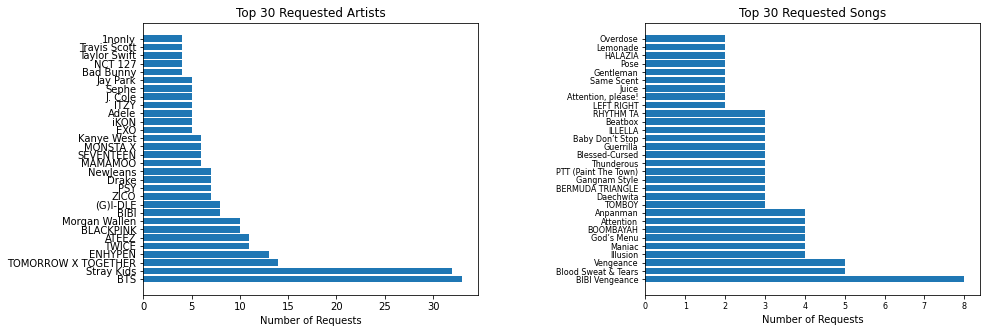

In [17]:
# Visualize the data using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

artists = df['Artist'].value_counts().head(30)
songs = df['Song'].value_counts().head(30)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.barh(artists.index, artists.values)
plt.title('Top 30 Requested Artists')
plt.xlabel('Number of Requests')

plt.subplot(1, 2, 2)
plt.barh(songs.index, songs.values)
plt.title('Top 30 Requested Songs')
plt.xlabel('Number of Requests')

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.subplots_adjust(wspace=0.5)
plt.savefig('song_request.pdf')  

In [12]:
# # Save the result in PDF format using ReportLab
# from reportlab.pdfgen import canvas
# from reportlab.lib.pagesizes import letter

# pdf = canvas.Canvas('song_requests_report.pdf', pagesize=letter)
# pdf.setFont('Helvetica', 12)
# pdf.drawString(30, 750, 'Top 10 Requested Artists')
# for i, artist in enumerate(artists.index):
#     pdf.drawString(30, 720 - i * 25, '{}. {}: {}'.format(i+1, artist, artists[artist]))
# pdf.drawString(30, 500, 'Top 10 Requested Songs')
# for i, song in enumerate(songs.index):
#     pdf.drawString(30, 470 - i * 25, '{}. {}: {}'.format(i+1, song, songs[song]))
# pdf.save()